# nn-cheatsheet
***notebook showing some best practices that I've stumbled upon in my couple years training emulators - I spent the time so you don't have to ;)***
___

The aim of this notebook is to take you through some clean, efficient ways to train emulators that should save you from making many of the same mistakes that I did!

This will include:
- ways to scale the data that might help with training
- a clean method for instantiating a (brute force) gridsearch algorithm of network architectures and hyperparams using `itertools.product`
- ways to name networks in an informative way that avoids overwriting (this will save you a lot of time later on!)
- failsafes to make sure we're saving networks often enough that an OOM error won't lose hours of training, and to make sure we're only saving the best performing weights and biases for a given network

There's likely other stuff I forgot. I'll try to remember to add these later!


In [338]:
import tensorflow as tf
import keras
from keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import corner
from itertools import product

plt.style.use("Solarize_Light2")
plt.rcParams.update({"axes.edgecolor": "black"})
plt.rcParams.update({"text.color": "black"})
plt.rcParams.update({"axes.labelcolor": "black"})
plt.rcParams.update({"xtick.color": "black"})
plt.rcParams.update({"ytick.color": "black"})
plt.rcParams.update({"font.family": "monospace"})

colours = plt.rcParams["axes.prop_cycle"].by_key()["color"]

## data scaling
(usually called *data augmentation* in ML circles, but this can scare astrophysicists!)
___
We'll start by generating some data for our networks to learn. let's try to get network to reproduce the functions:

$y_1 = \mathcal{f}_1(x_1, x_2, x_3) = x_1 + 2x_{2}^2 + 3x_{3}^3$,

$y_2 = \mathcal{f}_2(x_1, x_2, x_3) = -((x_1 -1) + 2(x_2 - 2)^2 + 3(x_3 -3)^3)$.

In this example, the $x_i$ terms are the *inputs* for our network, and the $y_i$ terms are our *outputs* - given a set of inputs $(x_1, x_2, x_3)$, we want our network to be able to accurately reproduce the functions $\mathcal{f}_1$ and $\mathcal{f}_2$ to give us $y_1$ and $y_2$, respectively.

In [295]:
def generate_data(data_range, data_N):
    return np.random.uniform(low=-data_range, high=data_range, size=data_N)
    
def f1(x1, x2, x3):
    y1 = x1 + 2*(x2**2) + 3*(x3**3)
    return y1


def f2(x1, x2, x3):
    y2 = -((x1-1) + 2*((x2-2)**2) + 3*((x3-3)**3))
    
    return y2

def input_plots(x1, x2, x3, y, alpha=0.01, s=3, ylabel = None, title=None):
    
    fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,4))

    colours = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    
    ax1.scatter(x1, y, alpha=alpha,s=s, c=colours[0])
    ax1.set_ylabel(ylabel)
    ax1.set_xlabel(r'$x_1$')

    ax2.scatter(x2, y, alpha=alpha,s=s, c=colours[1])
    ax2.yaxis.set_tick_params(labelleft=False)
    ax2.set_xlabel(r'$x_2$')
    
    ax3.scatter(x3, y, alpha=alpha,s=s, c=colours[2])
    ax3.yaxis.set_tick_params(labelleft=False)
    ax3.set_xlabel(r'$x_3$')

    plt.suptitle(title)
    plt.tight_layout()
    fig.subplots_adjust(wspace=0)
    fig.patch.set_alpha(0.0)
    plt.show()

Let's see what these functions look like in the range $-1<x_i<1$:

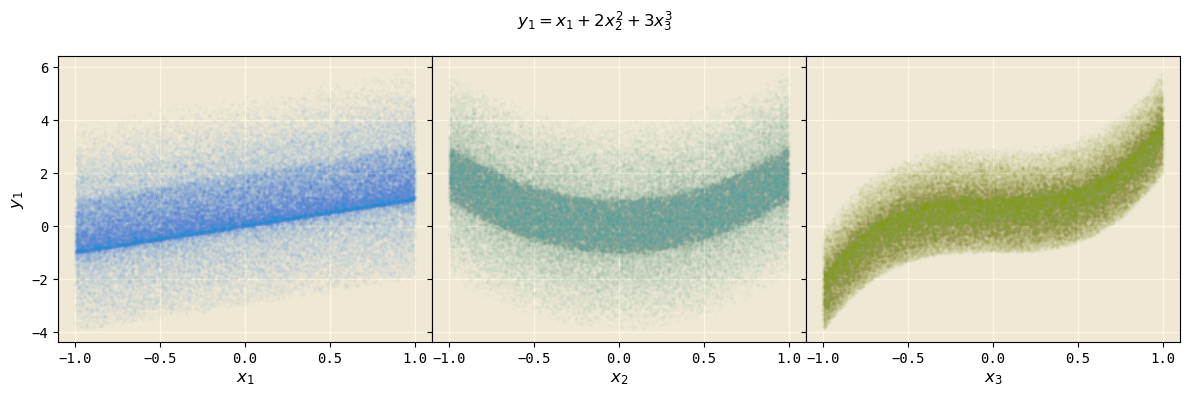

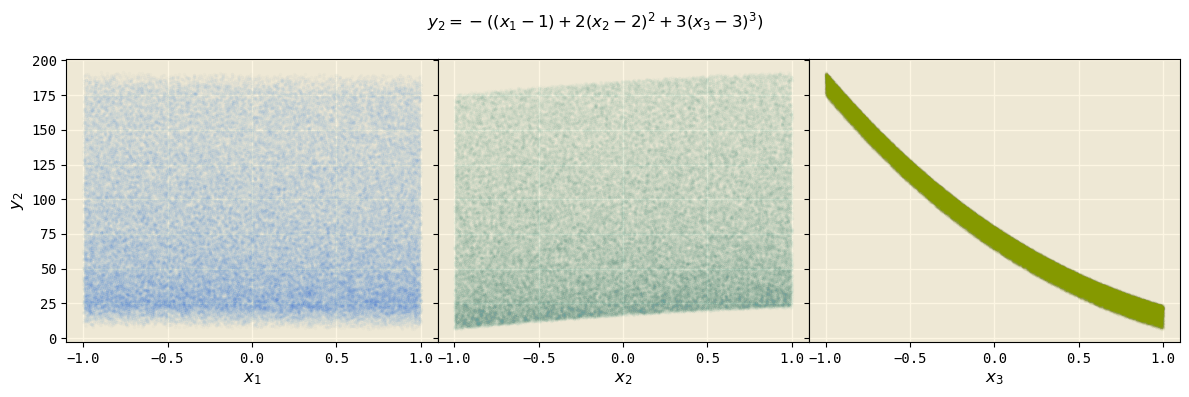

In [296]:
data_N = int(1e5)

x3_range = 1
x3 = generate_data(x3_range, data_N)

x2_range = 1
x2 = generate_data(x2_range, data_N)

x1_range = 1
x1 = generate_data(x1_range, data_N)

y1 = f1(x1, x2, x3)
y2 = f2(x1, x2, x3)

input_plots(x1,x2,x3,y1, ylabel = r'$y_1$', title=r'$y_1 = x_1 + 2x_{2}^2 + 3x_{3}^3$')
input_plots(x1,x2,x3,y2, ylabel = r'$y_2$', title=r'$y_2 = -((x_1 -1) + 2(x_2 - 2)^2 + 3(x_3 -3)^3)$')

Funky! But bold of use to assume that our inputs would even have a remotely similar dynamic range - astrophysics is the field of astronomically large numbers, after all.

Let's see what happens if we add some different orders of magnitude to this example:

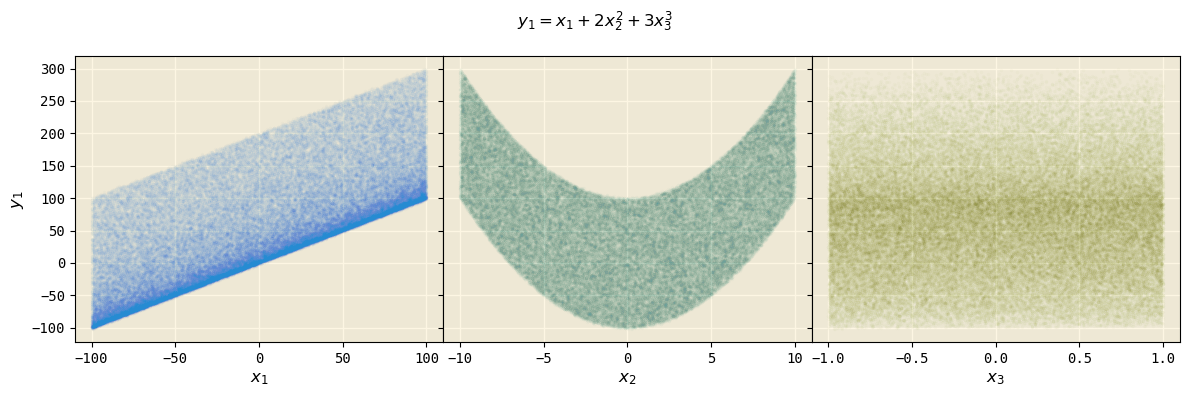

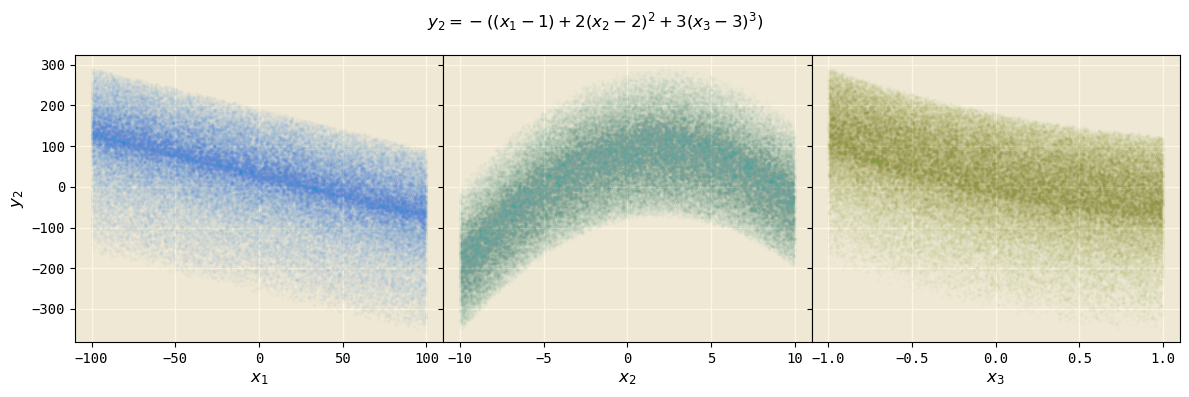

,x1,x2,x3,y1,y2
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,-0.136103,-0.023992,-0.002159,66.630367,16.356587
std,57.764421,5.777984,0.577477,83.239669,106.858274
min,-99.992796,-9.999872,-0.999992,-102.061116,-349.235248
25%,-50.150204,-5.048389,-0.503098,3.329515,-51.423977
50%,-0.531052,-0.027529,-0.005109,64.985119,23.447276
75%,49.805492,4.964760,0.498044,121.403996,92.725456
max,99.999543,9.999971,0.999999,298.791600,292.029738


In [297]:
data_N = int(1e5)

x3_range = 1
x3 = generate_data(x3_range, data_N)

x2_range = 10
x2 = generate_data(x2_range, data_N)

x1_range = 100
x1 = generate_data(x1_range, data_N)

y1 = f1(x1, x2, x3)
y2 = f2(x1, x2, x3)

input_plots(x1,x2,x3,y1, ylabel = r'$y_1$', title=r'$y_1 = x_1 + 2x_{2}^2 + 3x_{3}^3$')
input_plots(x1,x2,x3,y2, ylabel = r'$y_2$', title=r'$y_2 = -((x_1 -1) + 2(x_2 - 2)^2 + 3(x_3 -3)^3)$')

df = pd.DataFrame({
    "x1" : x1,
    "x2" : x2,
    "x3" : x3,
    "y1" : y1,
    "y2" : y2
})

df.describe()

We'll avoid going into too much detail here, but the way that neural networks adapt the neuron weights and biases during training means that a feature with comparitively large dynamic range (in this case, $x_1$) can lead to bizarre behaviour in our training - typically with weights becoming either very large or very small (look up exploding/vanishing gradients if you're interested).

An easy way around this is to scale our data using some easily reversible transformation prior to training.

Often this is only applied to the input data, but I have never seen a reason to *not* scale the outputs too - I reckon this can help prevent overflow errors with stupidly large predictions, if for instance the network is trying to predict outputs with a large dynamic range.

There are a few choices for this, but typically we'd choose either ***normalisation*** or ***standardisation***.

### normalisation
normalisation is the most common choice for when our variables are not normally distributed (like the dummy data we're using here, which is uniformly distributed).\
to normalise our data, we scale our parameters to all lie in the range $[0,1]$ (or sometimes $[-1,1]$) using the transformation

$x_i' = \frac{x_i-\text{min}(x_i)}{\text{max}(x_i)-\text{min}(x_i)}$

as follows:


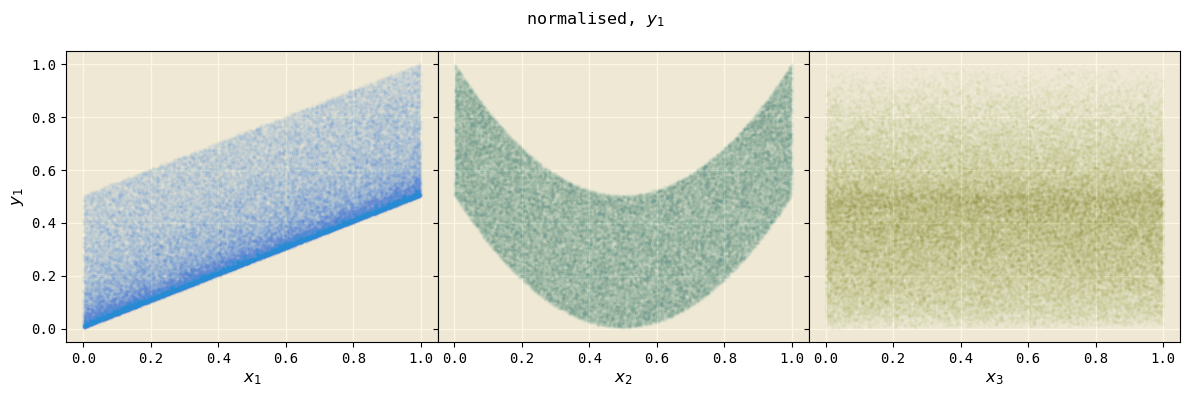

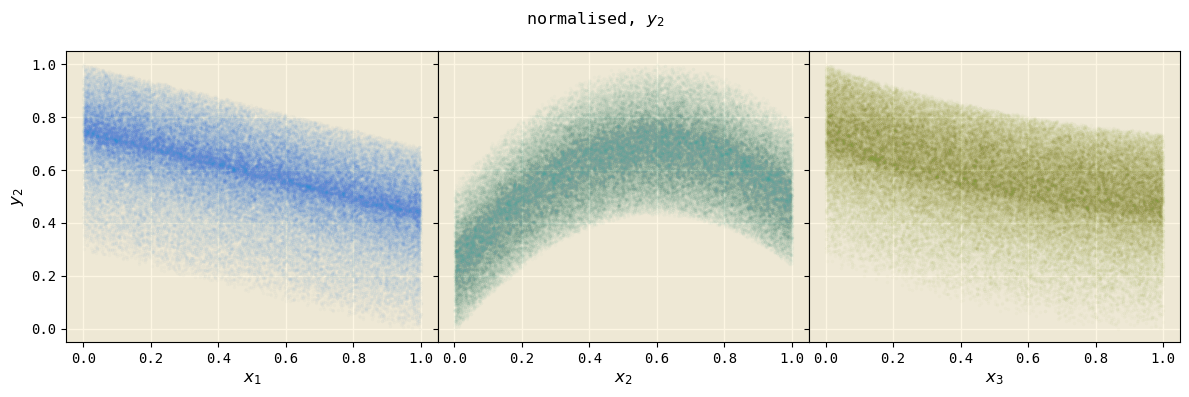

,x1_norm,x2_norm,x3_norm,y1_norm,y2_norm
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.499303,0.498798,0.498919,0.420832,0.570110
std,0.288833,0.288901,0.288740,0.207656,0.166637
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.249223,0.247576,0.248448,0.262916,0.464412
50%,0.497328,0.498621,0.497444,0.416727,0.581168
75%,0.749020,0.748238,0.749021,0.557474,0.689201
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [309]:
def normalise(df, column):
    values = df[column].values
    values_min = np.min(values)
    values_max = np.max(values)

    values_norm = (values - values_min)/(values_max - values_min)
    
    df[f"{column}_norm"] = values_norm

input_columns = ["x1", "x2", "x3"]
output_columns = ["y1","y2"]
columns = input_columns+output_columns

for column in columns:
    normalise(df,column)

input_plots(df["x1_norm"],df["x2_norm"],df["x3_norm"],df["y1_norm"], ylabel = r'$y_1$', title=r'normalised, $y_1$')
input_plots(df["x1_norm"],df["x2_norm"],df["x3_norm"],df["y2_norm"], ylabel = r'$y_2$', title=r'normalised, $y_2$')

df[[f"{column}_norm" for column in columns]].describe()

As we can see, these are all scaled nicely between 0 and 1 now, which should make things a lot easier for our network during training.

So long as we save the $\text{min}(x_i)$ and $\text{max}(x_i)$ values used to normalise, this is fully reversible:

$x_i = x_i'(\text{max}(x_i)-\text{min}(x_i)) + \text{min}(x_i)$

### standardisation

Another approach is standardisation, which is usually chosen when our dataset contains data that is close to normally distributed.
To standardise, we apply the transformation:

$x_i' = \frac{x_i - \bar{x_i}}{\sigma_{x_i}}$,

where $\bar{x_i}$ is the mean of the feature and $\sigma_{x_i}$ is the standard deviation.

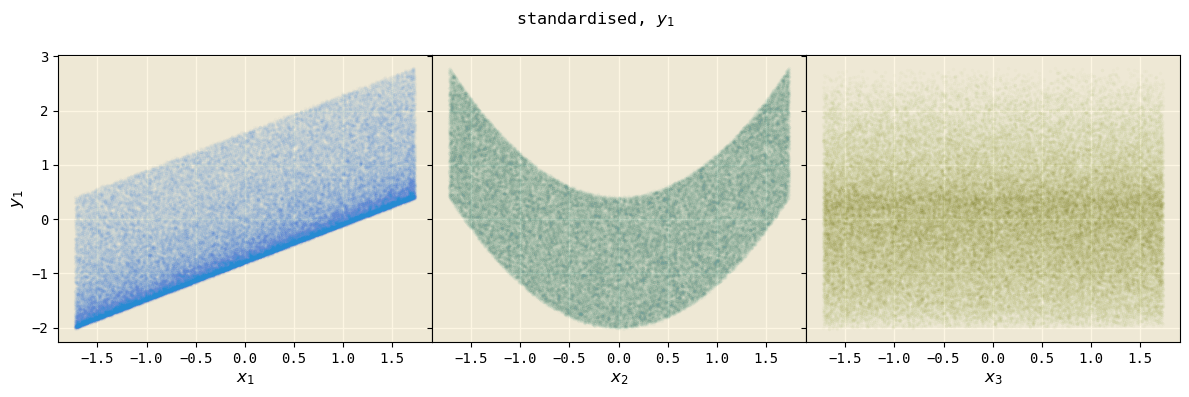

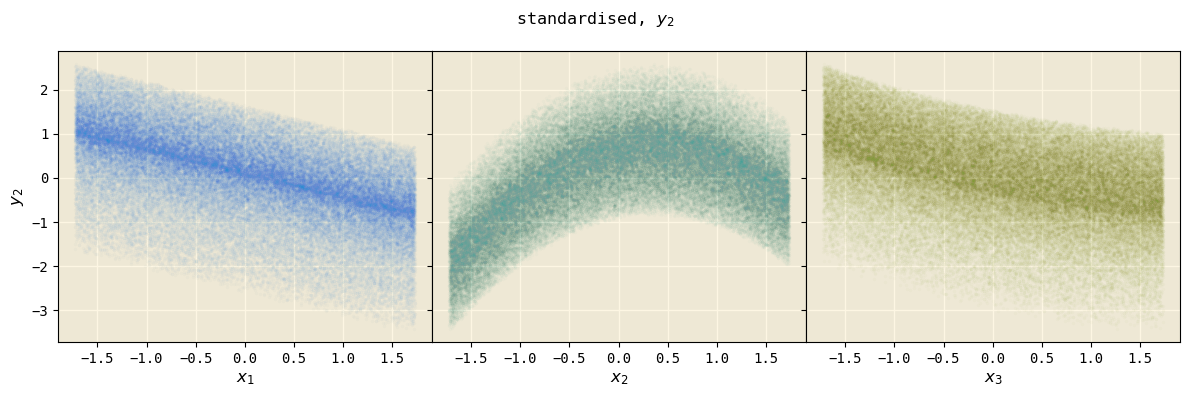

,x1_std,x2_std,x3_std,y1_std,y2_std
count,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05
mean,-2.494005e-17,3.083755e-17,-2.039258e-17,-3.346656e-17,9.041656e-18
std,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00
min,-1.728697e+00,-1.726542e+00,-1.727925e+00,-2.026586e+00,-3.421295e+00
25%,-8.658332e-01,-8.695805e-01,-8.674659e-01,-7.604688e-01,-6.343065e-01
50%,-6.837273e-03,-6.122203e-04,-5.107351e-03,-1.976528e-02,6.635635e-02
75%,8.645779e-01,8.634114e-01,8.661914e-01,6.580264e-01,7.146779e-01
max,1.733526e+00,1.734863e+00,1.735416e+00,2.789084e+00,2.579815e+00


In [298]:
def standardise(df, column):
    values = df[column].values
    values_mean = np.mean(values)
    values_std = np.std(values)

    values_std = (values - values_mean)/(values_std)
    
    df[f"{column}_std"] = values_std

input_columns = ["x1", "x2", "x3"]
output_columns = ["y1","y2"]
columns = input_columns+output_columns

for column in columns:
    standardise(df,column)

input_plots(df["x1_std"],df["x2_std"],df["x3_std"],df["y1_std"], ylabel = r'$y_1$', title=r'standardised, $y_1$')
input_plots(df["x1_std"],df["x2_std"],df["x3_std"],df["y2_std"], ylabel = r'$y_2$', title=r'standardised, $y_2$')

df[[f"{column}_std" for column in columns]].describe()

Again, this is absolutely reversible so long as we keep hold of the $\bar{x_i}$ and $\sigma_{x_i}$ used to scale the data:

$x_i = (\sigma_{x_i} \times x_i') + \bar{x_i}$

## gridsearch dataframe
As we know, neural networks are highly customisable in their architecture and hyperparameters.

Often, we're trying to find the best trade-off between a network that is complex enough to precisely approximate the functions we want it to learn, but not so complex that we begin to overfit to the training set (and become computationally slow to compute).

To find the "optimal" network, a typical procedure is a ***gridsearch*** routine.

Gridsearching involves populating a grid with potential network architecture and hyperparameter combinations that we want to try, and training each for a set number of epochs.

Once we've trained a network with each of our unique architecture combinations, we can compare the final loss score of each and see which one performed the best without overfitting.

Let's decide some basic architecture and hyperparameter choices for a network to train on our dataset, and populate a dataframe using `itertools.product`:

In [305]:
n_layers = [2,4,6]
n_neurons = [8,16,32]
activation = ['elu', 'relu']

architectures_df = pd.DataFrame(product(n_layers, n_neurons, activation), columns = ["n_layers", "n_neurons", "activation"])
architectures_df

,n_layers,n_neurons,activation
0,2,8,elu
1,2,8,relu
2,2,16,elu
3,2,16,relu
4,2,32,elu
5,2,32,relu
6,4,8,elu
7,4,8,relu
8,4,16,elu
9,4,16,relu


If each of the rows in this `architectures_df` dataframe is a unique combination of neural network architectures, then it's not hard to see how this can scale up very quickly ($N = \Pi\,\text{len(architecture parameter)}$) if we start to think about more complex architecture scenarios (batch normalisation, dropout fractions, varied neurons per layer, different optimisers... the list goes on!).

We'll come back to this dataframe in the next section, where we'll go over how we can use each row to create, train, and save a network with a different architecture.

I'll show you how get tensorflow to adopt network architectures and hyperparameters based on this dataframe, and hopefully it should make it fairly easy to make your own with more architecutre parameters!

## training loop
Now we have our dataframe of networks to gridsearch over, let's make a training loop so we can set our gridsearch routine going while we go and make a (your beverage of choice here).

First, lets split the dataset we generated and scaled earlier into a training, test, and validation set:

In [322]:
seed = 42

## pull training and validation from df and set aside remainder for test
df_train_val = df.sample(frac=0.9, random_state=seed)
df_test = df.drop(df_train_val.index)

## drop val from from training and validation
df_train = df_train_val.sample(frac=0.9, random_state=seed)
df_val = df_train_val.drop(df_train.index)

Because our data was not normally distributed, we'll use the normalised parameters as inputs and outputs:

In [323]:
inputs = ["x1_norm","x2_norm","x3_norm"]
outputs = ["y1_norm", "y2_norm"]

Now it's time to set up our training loop! We'll use the tensorflow functional API for the following.

Notice below that I define an `nn_name` variable that will be unique for each network based on the architecture, and is vaguely informative at first glance (`{n_layers}l_{n_neurons}n_{activation}` tells us how many layers and units we have). This prevents networks from overwriting one another, and means we can tell what archicture a network has just on a glance at the saved file. I'm sure there are much neater ways of doing this, or maybe specific naming conventions, but even this rough method will save us a headache later on!

There's going to be a few lines here that need explaining, so I'll try to leave comments as I go:


In [ ]:
tf.keras.backend.clear_session() #garbage collect of previous tensorflow models that might be hogging memory

for architecture_idx, architecture in architectures_df.iterrows():
    tf.keras.backend.clear_session()
    ######## input
    nn_input = keras.Input(shape=(len(inputs),)) #input always has shape = len(inputs)

    ######## dense layers
    ## unpack architecture parameters
    n_layers = int(architecture["n_layers"]) #n_layers, assure int
    n_neurons = int(architecture["n_neurons"]) #n_neurons, and assure int
    activation = architecture["activation"]

    ## loop to populate with dense layers
    for layer_idx in range(n_layers):
        if layer_idx == 0: #check if first layer
            nn_d_layer = layers.Dense(n_neurons, activation=activation)(nn_input)
        else:
            nn_d_layer = layers.Dense(n_neurons, activation=activation)(nn_d_layer)

    ######## output
    nn_output = layers.Dense(len(outputs), activation="linear")(nn_d_layer)

    ######## construct and name
    nn_name = f"{n_layers}l_{n_neurons}n_{activation}"
    nn_model = keras.Model(inputs=nn_input, outputs=nn_output, name=nn_name)

    ######## define optimiser and compile
    optimiser = tf.keras.optimizers.Adam(learning_rate = 0.001) # consider gridsearching over opt and lr too!
    nn_model.compile(loss="MSE", optimizer=optimiser)

    ######## define callbacks
    # callbacks are functions that are continuously called during training
    # these are really useful for monitoring p
    
    ######## fit model
    history = nn_model.fit(df_train[inputs],
                    df_train[outputs],
                    validation_data=(df_val[inputs],df_val[outputs]),
                    batch_size=2**10,
                    verbose=1,
                    epochs=100,
                    shuffle=True
                   )

Epoch 1/1000


I0000 00:00:1747996439.641812  315130 service.cc:146] XLA service 0x77c9cc005140 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747996439.641830  315130 service.cc:154]   StreamExecutor device (0): NVIDIA RTX A4500, Compute Capability 8.6
I0000 00:00:1747996439.641832  315130 service.cc:154]   StreamExecutor device (1): NVIDIA RTX A4500, Compute Capability 8.6
2025-05-23 11:33:59.659351: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-23 11:33:59.723099: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2025-05-23 11:33:59.745003: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:762] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which 

43/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7510 

I0000 00:00:1747996440.431925  315130 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.6108 - val_loss: 0.0848
Epoch 2/1000
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0666 - val_loss: 0.0416
Epoch 3/1000
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 0.0365 - val_loss: 0.0276
Epoch 4/1000
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - loss: 0.0254 - val_loss: 0.0213
Epoch 5/1000
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - loss: 0.0202 - val_loss: 0.0184
Epoch 6/1000
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - loss: 0.0179 - val_loss: 0.0172
Epoch 7/1000
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 0.0167 - val_loss: 0.0165
Epoch 8/1000
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - loss: 0.0163 - val_loss: 0.0161
Epoch 9/1000
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - loss: 0.0159 - val_loss: 0.0158
Epoch 10/1000
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - loss: 0.0157 - val_loss: 0.0156
Epoch 11/1000
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - loss: 0.0154 - val_loss: 0.0153
Epoch 12/1000
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 78

2025-05-23 11:35:20.311067: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_304', 2772 bytes spill stores, 2648 bytes spill loads



80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.1863 - val_loss: 0.0522
Epoch 2/1000
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0393 - val_loss: 0.0260
Epoch 3/1000
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - loss: 0.0248 - val_loss: 0.0210
Epoch 4/1000
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - loss: 0.0202 - val_loss: 0.0176
Epoch 5/1000
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - loss: 0.0169 - val_loss: 0.0145
Epoch 6/1000
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - loss: 0.0139 - val_loss: 0.0114
Epoch 7/1000
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 0.0109 - val_loss: 0.0089
Epoch 8/1000
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - loss: 0.0085 - val_loss: 0.0069
Epoch 9/1000
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - loss: 0.0065 - val_loss: 0.0051
Epoch 10/1000
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - loss: 0.0047 - val_loss: 0.0032
Epoch 11/1000
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - loss: 0.0029 - val_loss: 0.0021
Epoch 12/1000
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 78

if this sounds like a brute-force, trial-and-error, stumbling-around-in-the-dark type approach, that's because it is... without domain specific knowledge and prior intuition about what complexity we might need beforehand, it can be difficult to know what type of network will perform well before we start training.\
this is the time consuming part of making neural network emulators, especially if you have high standards for the final network's precision - I hope you like watching loss scores decrease and progress bars fill up!